# Subspecies CNN
This notebook covers the construction and fitting of CNN models to predict the subspecies of a honey bee based on it's image. Filepaths are configured such that the Capstone repo should be uploaded to Google Drive.

### Imports

In [ ]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import imageio
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import compute_class_weight
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras import utils
import tensorflow

#### Mount Google Drive
  - if forking and cloning from Github repo, upload entire Capstone folder to the default `~/MyDrive/` location in Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Global Variables

In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/Capstone/data/bee_imgs/'
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100
IMAGE_CHANNELS = 3
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2
CONV_2D_DIM_1 = 16
CONV_2D_DIM_2 = 16
CONV_2D_DIM_3 = 32
CONV_2D_DIM_4 = 64
MAX_POOL_DIM = 2
KERNEL_SIZE = 3
BATCH_SIZE = 32
PATIENCE = 5
NO_EPOCHS_1 = 5
NO_EPOCHS_2 = 10
NO_EPOCHS_3 = 50

In [ ]:
# Test file retrieval from directory
os.listdir(IMAGE_PATH)[:10]

['039_005.png',
 '041_071.png',
 '041_075.png',
 '040_261.png',
 '041_014.png',
 '040_234.png',
 '038_304.png',
 '040_522.png',
 '037_021.png',
 '040_087.png']

### Read In Cleaned Data with Image Dimensions

In [ ]:
bee_df = pd.read_csv('/content/drive/MyDrive/Capstone/data/bee_data_w_image.csv')

## Train-test-split

In [ ]:
train_df, test_df = train_test_split(bee_df, test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE, 
                                     stratify=bee_df['subspecies'])

In [ ]:
train_df, val_df = train_test_split(train_df, test_size=VAL_SIZE, 
                                    random_state=RANDOM_STATE, 
                                    stratify=train_df['subspecies'])

In [ ]:
print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))
print("Val   set rows: {}".format(val_df.shape[0]))

Train set rows: 3309
Test  set rows: 1035
Val   set rows: 828


In [ ]:
# Training Set Target Occurances
train_df['subspecies'].value_counts(normalize=True)

Italian honey bee        0.581445
Russian honey bee        0.101843
Carniolan honey bee      0.097008
1 Mixed local stock 2    0.091266
Unknown                  0.082804
VSH Italian honey bee    0.038380
Western honey bee        0.007253
Name: subspecies, dtype: float64

In [ ]:
# Validation Set Target Occurances
val_df['subspecies'].value_counts(normalize=True)

Italian honey bee        0.582126
Russian honey bee        0.101449
Carniolan honey bee      0.096618
1 Mixed local stock 2    0.091787
Unknown                  0.082126
VSH Italian honey bee    0.038647
Western honey bee        0.007246
Name: subspecies, dtype: float64

In [ ]:
# Testing Set Target Occurances
test_df['subspecies'].value_counts(normalize=True)

Italian honey bee        0.581643
Russian honey bee        0.102415
Carniolan honey bee      0.096618
1 Mixed local stock 2    0.090821
Unknown                  0.083092
VSH Italian honey bee    0.038647
Western honey bee        0.006763
Name: subspecies, dtype: float64

## Imbalanced Classes

 - The data is highly imbalanced with respect to most frequent occuring value in our target, subspecies. The number of Italian Honey Bees in our training set greatly outnumbers the other classes, by almost 6:1 at the highest ratio.

 - To solve this, I will use the `compute_class_weight` function from `sklearn.utils`. This outputs an array of class weights, according to the class labels.

In [ ]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_df.subspecies), y = train_df.subspecies)


In [ ]:
class_weights

array([ 1.56527909,  1.47263017,  0.2456935 ,  1.40271301,  1.72523462,
        3.72215973, 19.69642857])

 - For the model to accept class weights, they need to be in the form of a dictionary, where the keys are integer indices of the class labels, and the values are the corresponding class weight.

In [ ]:
class_int_labels = [i for i in range(0,len(class_weights))]
class_weights = dict(zip(class_int_labels, class_weights))

In [ ]:
class_weights

{0: 1.565279091769158,
 1: 1.472630173564753,
 2: 0.2456934956934957,
 3: 1.4027130139889783,
 4: 1.7252346193952033,
 5: 3.722159730033746,
 6: 19.696428571428573}

### Defining Functions For Reading Images and Data

The function below will read an image, resize it to 100x100 px, and return the pixel data from the image.

In [ ]:
def read_image(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    image = skimage.transform.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), mode='reflect')
    return image[:,:,:IMAGE_CHANNELS]

The function below will iterate through the list of files, and apply the image reading function, then stack all the image data from all files, and set X to equal the image data. It will also get dummy variables for the target, and return X and y.

In [ ]:
def categories_encoder(dataset, var='subspecies'):
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

In [ ]:
X_train, y_train = categories_encoder(train_df)
X_val, y_val = categories_encoder(val_df)
X_test, y_test = categories_encoder(test_df)

## Baseline

In [ ]:
bee_df.subspecies.value_counts(normalize=True)

Italian honey bee        0.581593
Russian honey bee        0.101895
Carniolan honey bee      0.096868
1 Mixed local stock 2    0.091261
Unknown                  0.082753
VSH Italian honey bee    0.038476
Western honey bee        0.007154
Name: subspecies, dtype: float64

As this is a multi-class classification problem, we can consider our baseline accuracy to be the occurance of the majority class. In our case, this is the Italian Honey Bee, with a 58.15% accuracy. Any improvement of the per-class accuracies and total accuracy will be considered an improvement.

## CNN

In order for our CNN to efficiently compute weights, the pixel data must be normalized to a minimum of 0 and a maximum of 1.

In [ ]:
X_train.max(), X_val.max(), X_test.max()

(1.0, 1.0, 1.0)

In [ ]:
X_train.min(), X_val.min(), X_test.min()

(0.0, 0.0, 0.0)

## Building The Model Architecture
 - The initial CNN is a sequential model, with two convolutional layers and 1 MaxPooling layer to reduce dimensionality. We use the Adam optimizer, compute the categorical crossentropy loss function, and measure accuracy.

 - When fitting, the dictionary created previously, `class_weights`, is passed to the parameter of `class_weight` to resolve imbalanced classes.

In [ ]:
model1 = Sequential()


model1.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model1.add(MaxPool2D(MAX_POOL_DIM))
model1.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model1.add(Flatten())
model1.add(Dense(y_train.columns.size, activation='softmax'))


model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 16)        2320      
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               (None, 7)                 280007    
                                                                 
Total params: 282,775
Trainable params: 282,775
Non-trainable params: 0
__________________________________________________

In [ ]:
history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=256,
    class_weight= class_weights,
    verbose=1
)

Epoch 1/10
13/13 [==============================] - 10s 105ms/step - loss: 3.0098 - accuracy: 0.1541 - val_loss: 1.6529 - val_accuracy: 0.4553
Epoch 2/10
13/13 [==============================] - 1s 48ms/step - loss: 1.7331 - accuracy: 0.4065 - val_loss: 1.4651 - val_accuracy: 0.4879
Epoch 3/10
13/13 [==============================] - 1s 49ms/step - loss: 1.2805 - accuracy: 0.5588 - val_loss: 1.0673 - val_accuracy: 0.6039
Epoch 4/10
13/13 [==============================] - 1s 50ms/step - loss: 0.9803 - accuracy: 0.6177 - val_loss: 0.9664 - val_accuracy: 0.6691
Epoch 5/10
13/13 [==============================] - 1s 49ms/step - loss: 0.6934 - accuracy: 0.6745 - val_loss: 0.8469 - val_accuracy: 0.7186
Epoch 6/10
13/13 [==============================] - 1s 49ms/step - loss: 0.5657 - accuracy: 0.7183 - val_loss: 0.7979 - val_accuracy: 0.7222
Epoch 7/10
13/13 [==============================] - 1s 48ms/step - loss: 0.4575 - accuracy: 0.7770 - val_loss: 0.6834 - val_accuracy: 0.7814
Epoch 8/10


### Plotting Accuracy and Loss

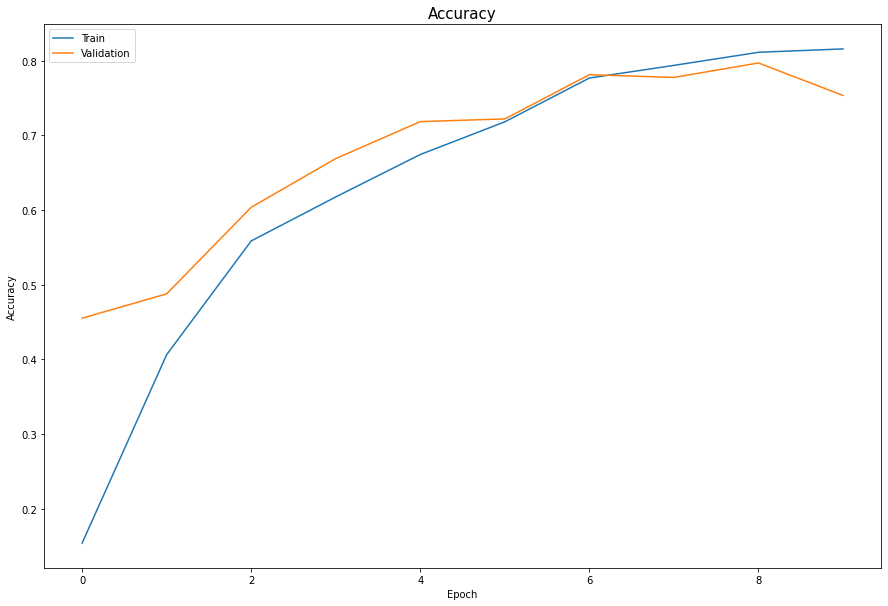

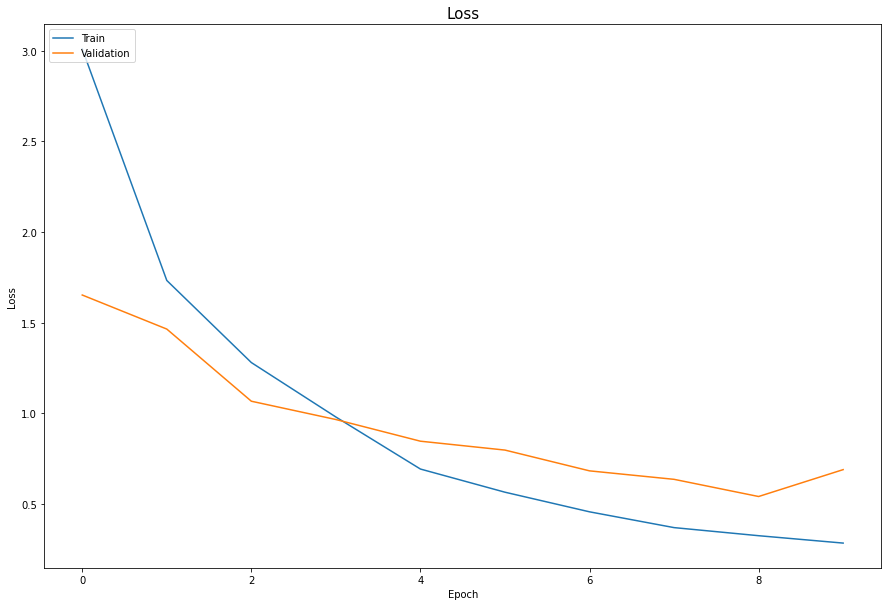

In [ ]:
# summarize history for accuracy
def plot_acc_and_loss(model):
  plt.figure(figsize=(15,10))
  plt.plot(model.history['accuracy'])
  plt.plot(model.history['val_accuracy'])
  plt.title('Accuracy', fontsize = 15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()
# summarize history for loss
  plt.figure(figsize=(15,10))
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('Loss', fontsize = 15)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

plot_acc_and_loss(history1)

### With Image Augmentation
 - `ImageDataGenerator` augments image data in real time and passes it through to the model to fit.
 - Augmentations include random width and height shifts, random zoom, random rotation, and horizontal and vertical flips.

In [ ]:
image_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=180,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True,
        vertical_flip=True)
image_generator.fit(X_train)

In [ ]:
model1_train = model1.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_2,
                        validation_data=[X_val, y_val],
                        class_weight = class_weights,
                        steps_per_epoch=len(X_train)/BATCH_SIZE                        
                        )

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


103/103 [==============================] - 8s 75ms/step - loss: 0.9205 - accuracy: 0.5975 - val_loss: 0.9623 - val_accuracy: 0.7222
Epoch 2/10
103/103 [==============================] - 8s 74ms/step - loss: 0.8125 - accuracy: 0.6331 - val_loss: 0.7604 - val_accuracy: 0.7222
Epoch 3/10
103/103 [==============================] - 8s 75ms/step - loss: 0.8463 - accuracy: 0.6053 - val_loss: 0.8626 - val_accuracy: 0.7041
Epoch 4/10
103/103 [==============================] - 8s 76ms/step - loss: 0.5879 - accuracy: 0.6697 - val_loss: 0.8599 - val_accuracy: 0.6775
Epoch 5/10
103/103 [==============================] - 9s 88ms/step - loss: 0.5963 - accuracy: 0.6945 - val_loss: 1.0249 - val_accuracy: 0.5990
Epoch 6/10
103/103 [==============================] - 8s 75ms/step - loss: 0.8763 - accuracy: 0.5842 - val_loss: 0.8470 - val_accuracy: 0.6123
Epoch 7/10
103/103 [==============================] - 8s 73ms/step - loss: 0.7289 - accuracy: 0.6343 - val_loss: 0.7690 - val_accuracy: 0.7162
Epoch 8/10

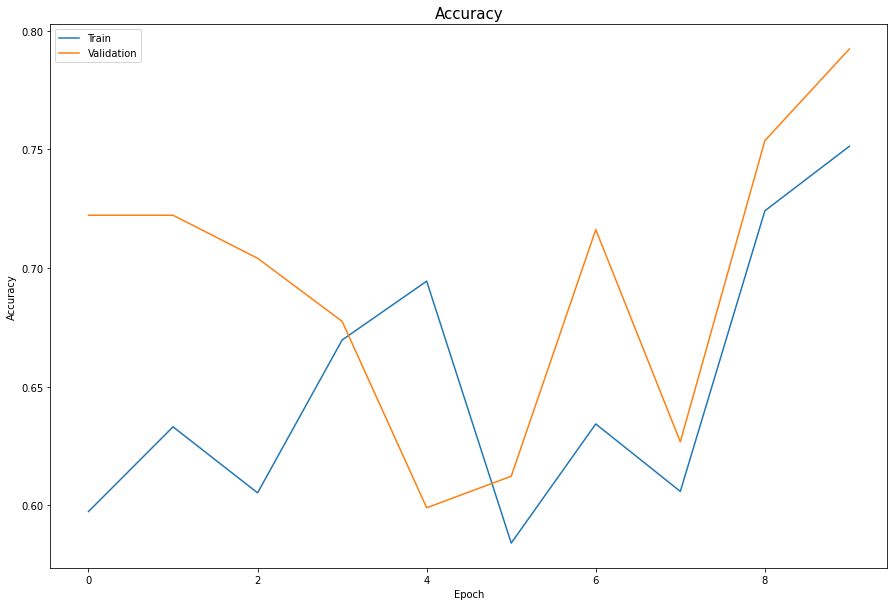

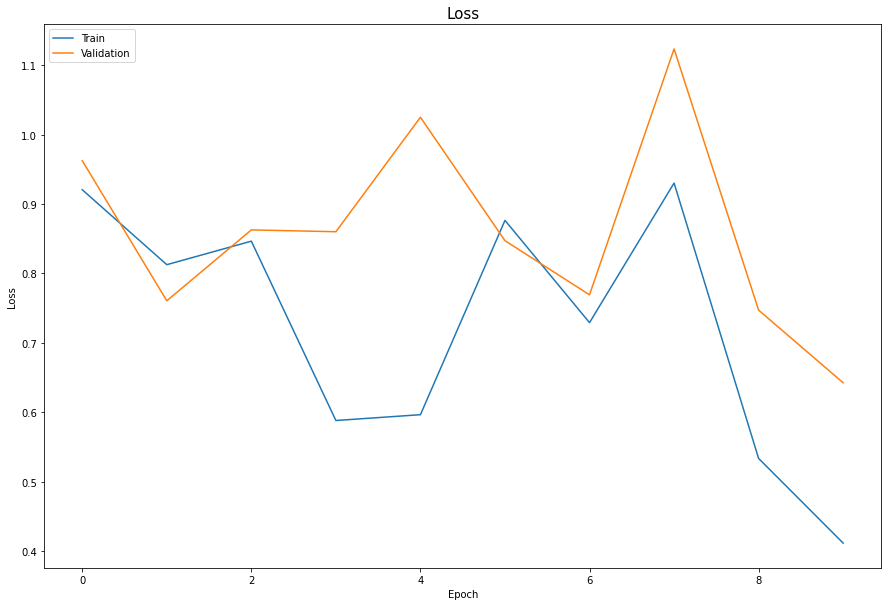

In [ ]:
plot_acc_and_loss(model1_train)

### Model Evaluation

In [ ]:
score = model1.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

33/33 [==============================] - 0s 7ms/step - loss: 0.5537 - accuracy: 0.8106
Test loss: 0.5537447333335876
Test accuracy: 0.8106279969215393


In [ ]:
# A function to generate a classification report and print model evaluation metrics
def test_accuracy_report(model):
    predicted = model.predict(X_test)
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(y_test.values, axis=1)
    print(metrics.classification_report(test_truth, test_predicted, target_names=y_test.columns)) 
    test_res = model.evaluate(X_test, y_test.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

In [ ]:
test_accuracy_report(model1)

33/33 [==============================] - 0s 4ms/step
                       precision    recall  f1-score   support

1 Mixed local stock 2       0.48      0.97      0.64        94
  Carniolan honey bee       0.89      0.96      0.92       100
    Italian honey bee       0.98      0.73      0.84       602
    Russian honey bee       0.95      0.99      0.97       106
              Unknown       0.53      0.77      0.63        86
VSH Italian honey bee       0.75      0.90      0.82        40
    Western honey bee       0.75      0.86      0.80         7

             accuracy                           0.81      1035
            macro avg       0.76      0.88      0.80      1035
         weighted avg       0.88      0.81      0.82      1035

Loss function: 0.5537447333335876, accuracy: 0.8106279969215393


Precision and recall scores are fairly high for certain classes. To resolve overfitting, dropout layers are introduced.

### CNN with Dropout Layers

In [ ]:
model_drop=Sequential()
model_drop.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model_drop.add(MaxPool2D(MAX_POOL_DIM))
# Dropout Layer
model_drop.add(Dropout(0.4))
model_drop.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
# Dropout Layer
model_drop.add(Dropout(0.4))
model_drop.add(Flatten())
model_drop.add(Dense(y_train.columns.size, activation='softmax'))
model_drop.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_drop_train  = model_drop.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_2,
                        validation_data=[X_val, y_val],
                        class_weight = class_weights,
                        steps_per_epoch=len(X_train)/BATCH_SIZE
                        )

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


103/103 [==============================] - 8s 77ms/step - loss: 1.5007 - accuracy: 0.4050 - val_loss: 1.2747 - val_accuracy: 0.5411
Epoch 2/10
103/103 [==============================] - 8s 74ms/step - loss: 0.8025 - accuracy: 0.5911 - val_loss: 0.8938 - val_accuracy: 0.6643
Epoch 3/10
103/103 [==============================] - 8s 74ms/step - loss: 0.6264 - accuracy: 0.6621 - val_loss: 0.7638 - val_accuracy: 0.7005
Epoch 4/10
103/103 [==============================] - 8s 75ms/step - loss: 0.5513 - accuracy: 0.7014 - val_loss: 0.7957 - val_accuracy: 0.6860
Epoch 5/10
103/103 [==============================] - 8s 76ms/step - loss: 0.4435 - accuracy: 0.7283 - val_loss: 0.6341 - val_accuracy: 0.7693
Epoch 6/10
103/103 [==============================] - 8s 75ms/step - loss: 0.4264 - accuracy: 0.7643 - val_loss: 1.0068 - val_accuracy: 0.6993
Epoch 7/10
103/103 [==============================] - 8s 74ms/step - loss: 0.5949 - accuracy: 0.7063 - val_loss: 0.5081 - val_accuracy: 0.8261
Epoch 8/10

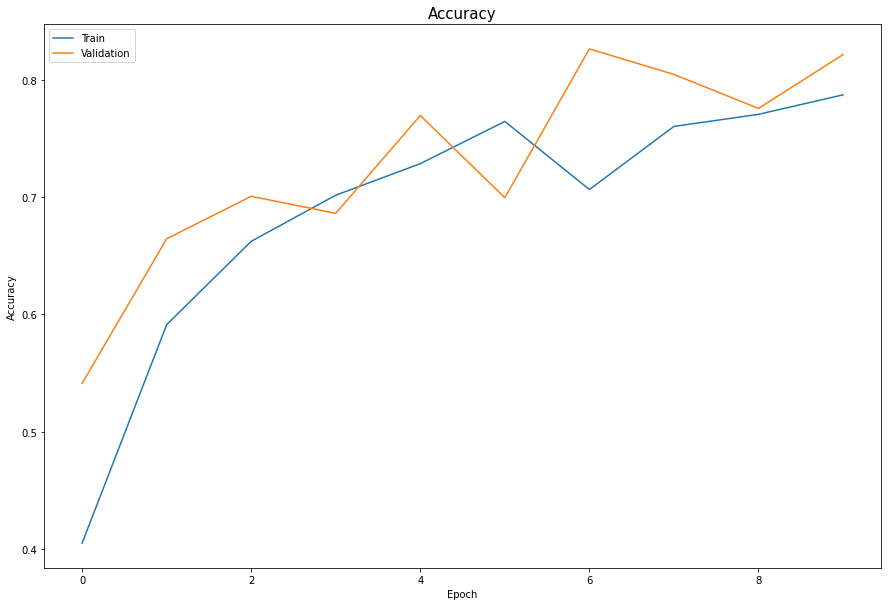

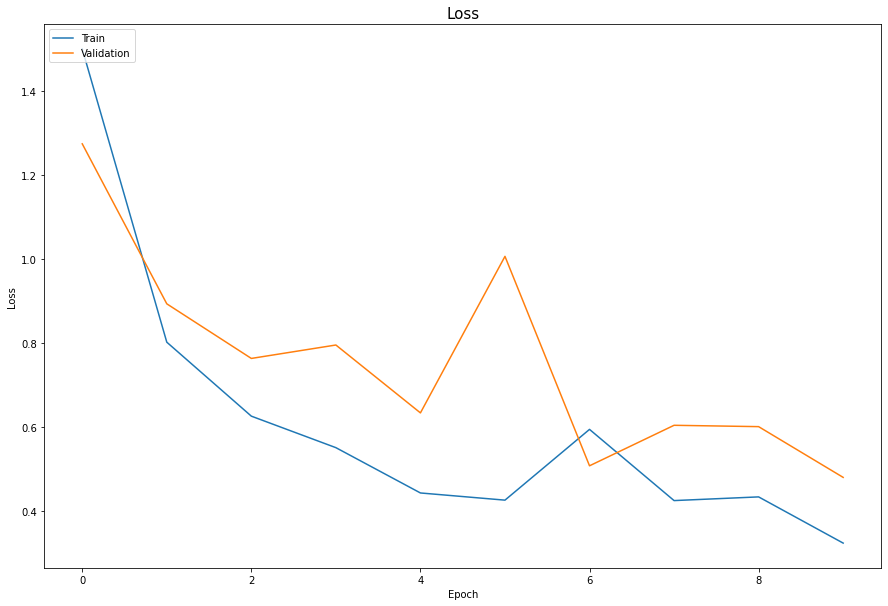

In [ ]:
plot_acc_and_loss(model_drop_train)

In [ ]:
test_accuracy_report(model_drop)

33/33 [==============================] - 0s 4ms/step
                       precision    recall  f1-score   support

1 Mixed local stock 2       0.46      0.98      0.63        94
  Carniolan honey bee       0.91      0.95      0.93       100
    Italian honey bee       0.99      0.77      0.86       602
    Russian honey bee       0.95      0.99      0.97       106
              Unknown       0.68      0.72      0.70        86
VSH Italian honey bee       0.77      0.93      0.84        40
    Western honey bee       0.54      1.00      0.70         7

             accuracy                           0.83      1035
            macro avg       0.76      0.90      0.80      1035
         weighted avg       0.89      0.83      0.84      1035

Loss function: 0.45491859316825867, accuracy: 0.8309178948402405


Our model has reduced it accuracy due to the dropout layers. We will retrain the model using more epochs, and incorporating changes to the learning rate.

### CNN with dropout layers and modified learning rate

 - The learning rate is the change in the model based on the error. Adjusting the learning rate as the model trains can result in greater accuracy by decreasing the learning rate progressively, which has the trade-off of potentially making the model take longer to converge.
 - An early stopping function is incorporated as well, to stop training when the model does not improve for more than 5 epochs.

In [ ]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.995 ** (x+NO_EPOCHS_3))
earlystopper = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=1)

In [ ]:
model_lr=Sequential()
model_lr.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model_lr.add(MaxPool2D(MAX_POOL_DIM))
# Add dropouts to the model
model_lr.add(Dropout(0.4))
model_lr.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
# Add dropouts to the model
model_lr.add(Dropout(0.4))
model_lr.add(Flatten())
model_lr.add(Dense(y_train.columns.size, activation='softmax'))
model_lr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_model_lr  = model_lr.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_3,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE,
                        class_weight = class_weights,
                        callbacks=[earlystopper, annealer]
                        )

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


103/103 [==============================] - 9s 78ms/step - loss: 1.8870 - accuracy: 0.2795 - val_loss: 2.0905 - val_accuracy: 0.2162 - lr: 7.7831e-04
Epoch 2/50
103/103 [==============================] - 8s 82ms/step - loss: 0.9871 - accuracy: 0.5168 - val_loss: 1.9044 - val_accuracy: 0.2802 - lr: 7.7442e-04
Epoch 3/50
103/103 [==============================] - 8s 75ms/step - loss: 0.7640 - accuracy: 0.5975 - val_loss: 0.9819 - val_accuracy: 0.6401 - lr: 7.7055e-04
Epoch 4/50
103/103 [==============================] - 8s 74ms/step - loss: 0.6768 - accuracy: 0.6222 - val_loss: 1.2465 - val_accuracy: 0.5676 - lr: 7.6670e-04
Epoch 5/50
103/103 [==============================] - 8s 74ms/step - loss: 0.5419 - accuracy: 0.6930 - val_loss: 1.1357 - val_accuracy: 0.6063 - lr: 7.6286e-04
Epoch 6/50
103/103 [==============================] - 8s 75ms/step - loss: 0.5091 - accuracy: 0.6881 - val_loss: 1.0289 - val_accuracy: 0.6461 - lr: 7.5905e-04
Epoch 7/50
103/103 [==============================]

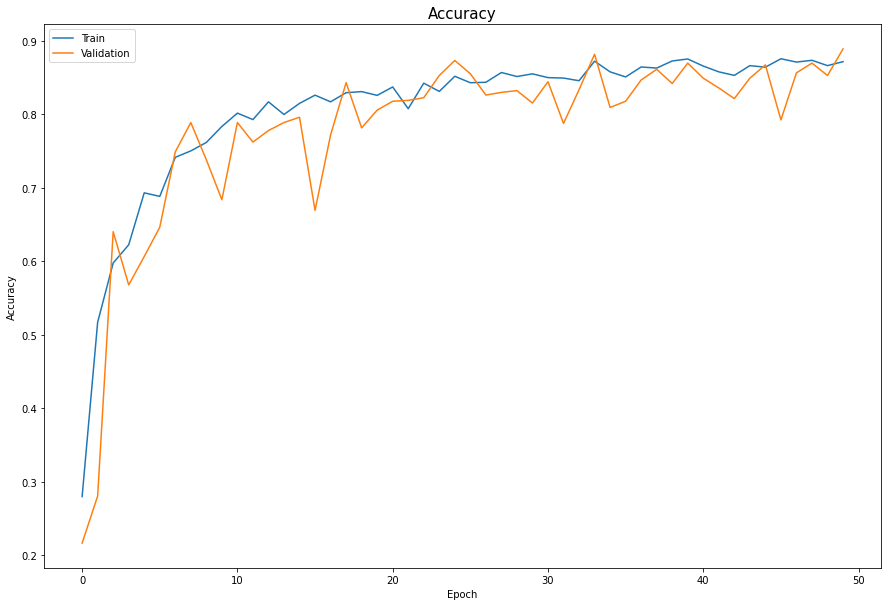

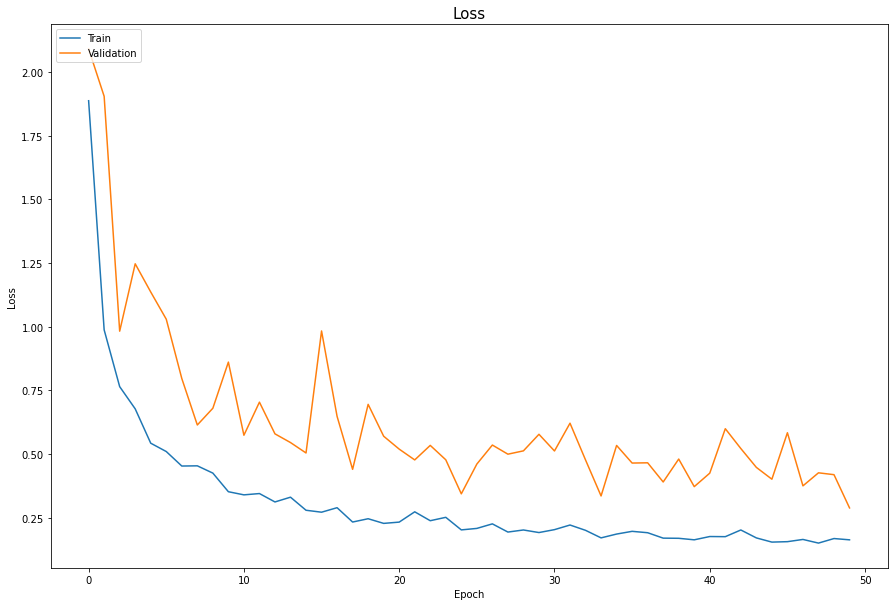

In [ ]:
plot_acc_and_loss(train_model_lr)

In [ ]:
test_preds = model_lr.predict(X_test)

33/33 [==============================] - 0s 4ms/step


In [ ]:
test_preds = np.argmax(test_preds, axis = 1)
test_true = np.argmax(y_test.values, axis = 1)

In [ ]:
test_accuracy_report(model_lr)

33/33 [==============================] - 0s 4ms/step
                       precision    recall  f1-score   support

1 Mixed local stock 2       0.52      0.99      0.68        94
  Carniolan honey bee       0.99      0.99      0.99       100
    Italian honey bee       0.99      0.84      0.91       602
    Russian honey bee       0.99      1.00      1.00       106
              Unknown       0.92      0.88      0.90        86
VSH Italian honey bee       0.81      0.95      0.87        40
    Western honey bee       1.00      0.86      0.92         7

             accuracy                           0.89      1035
            macro avg       0.89      0.93      0.90      1035
         weighted avg       0.93      0.89      0.90      1035

Loss function: 0.23701506853103638, accuracy: 0.8927536010742188


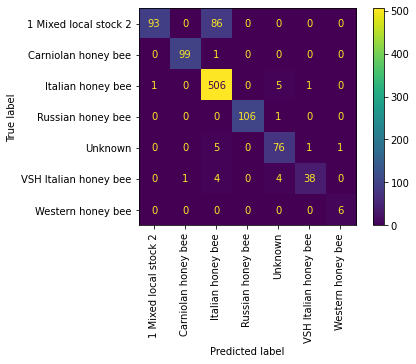

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(test_preds, 
                                        test_true, 
                                        display_labels = list(y_test.columns),
                                        xticks_rotation = 'vertical');

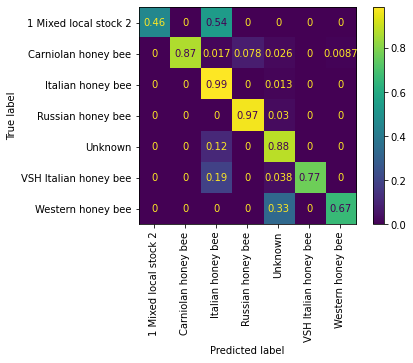

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(test_preds, 
                                        test_true, 
                                        display_labels = list(y_test.columns),
                                        xticks_rotation = 'vertical',
                                        normalize = 'true');

This model achieved an accuracy of 89.27%, greatly improved from the baseline accuracy of 58%.

In [ ]:
# Uncomment to over-write models
#model1.save('/content/drive/MyDrive/Capstone/models/model_1_subspecies_bal')
#model_drop.save('/content/drive/MyDrive/Capstone/models/model_drop_subspecies_bal')
#model_lr.save('/content/drive/MyDrive/Capstone/models/model_lr_subspecies_bal')